In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from pathlib import Path
import re
from visu_utils import TASK_LIST_CLASSIFICATION, make_results_tables_per_group_size, load_classification_merged_mteb

from autorank import autorank, plot_stats, create_report, latex_table

EXPORT_PATH_TABLE = Path("../../papers/Distillation-MI-ICLR/tables/nlp/")
EXPORT_PATH_FIG = Path("../../papers/Distillation-MI-ICLR/figures/nlp/")

# Make sure the folders exist
EXPORT_PATH_TABLE.mkdir(parents=True, exist_ok=True)
EXPORT_PATH_FIG.mkdir(parents=True, exist_ok=True)

%reload_ext autoreload
%autoreload 2


In [2]:

# load mteb classification

MTEB_BASELINES_PATH = Path("../non_sync/baselines_mteb/mteb_detailed/en_Classification.csv")

RESULTS_PATHS = [Path("../non_sync/mteb_benchmarking/results/experiments_gist_nll"),
                 Path("../non_sync/mteb_benchmarking/results/experiments_gist_mse")
                 ]



df_merged = load_classification_merged_mteb(MTEB_BASELINES_PATH, RESULTS_PATHS)


# Keep models with only Model Size (Million Parameters) between 10 and 300
df_merged = df_merged[
    (df_merged['Model Size (Million Parameters)'] >= 10) & (df_merged['Model Size (Million Parameters)'] <= 450)]

df_merged = df_merged.drop_duplicates()

# select only last training step for each model
df_merged = df_merged.reset_index()

indices = df_merged.sort_values('Training step').groupby('Model')['Training step'].idxmax()
df_merged = df_merged.loc[indices]
df_merged = df_merged.drop('Training step', axis=1)


df_merged
# melt columns back into rows with Accuracy
df_melted = df_merged.melt(id_vars=['Model', 'Model Size (Million Parameters)', 'loss', 'Dataset'],
                           value_vars=df_merged.columns[4:], var_name='Task', value_name='Accuracy')


In [3]:

# Rank models for each task by Accuracy

df_melted['Rank'] = df_melted.groupby('Task')['Accuracy'].rank(ascending=False, method='min')

In [4]:
# Add loss to Model name "{model}-{loss}" if loss is not MTEB

df_melted['Model'] = df_melted.apply(lambda x: f"{x['Model']} - {x['loss']}" if x['loss'] != 'MTEB' else x['Model'], axis=1)

In [17]:

def make_rank_heatmap_with_mask(df_rank, ax, common_kwargs):
    
    # make a mask that is True for the best value per line
    mask = df_rank == df_rank.min(axis=1).values[:, None]
    
    # make annot table with everything underline, a square np array
    
    annot_underline = np.empty(df_rank.shape, dtype=object)
    for i in range(df_rank.shape[0]):
        for j in range(df_rank.shape[1]):
            annot_underline[i, j] = f"\\textbf{{\\underline{{{df_rank.iloc[i, j]:.0f}}}}}"
            
            
    annot = np.empty(df_rank.shape, dtype=object)
    for i in range(df_rank.shape[0]):
        for j in range(df_rank.shape[1]):
            annot[i, j] = f"{df_rank.iloc[i, j]:.0f}"
    
    # format the sns with underline 
    sns.heatmap(df_rank, ax=ax, cmap='flare', annot_kws={"size": 8}, annot=annot_underline, fmt="", cbar=False, mask=~mask, **common_kwargs)
    
    # format the sns with the values
    sns.heatmap(df_rank, ax=ax, cmap='flare', annot_kws={"size": 8}, annot=annot, fmt="", cbar=False, mask=mask, **common_kwargs)
    
    
    



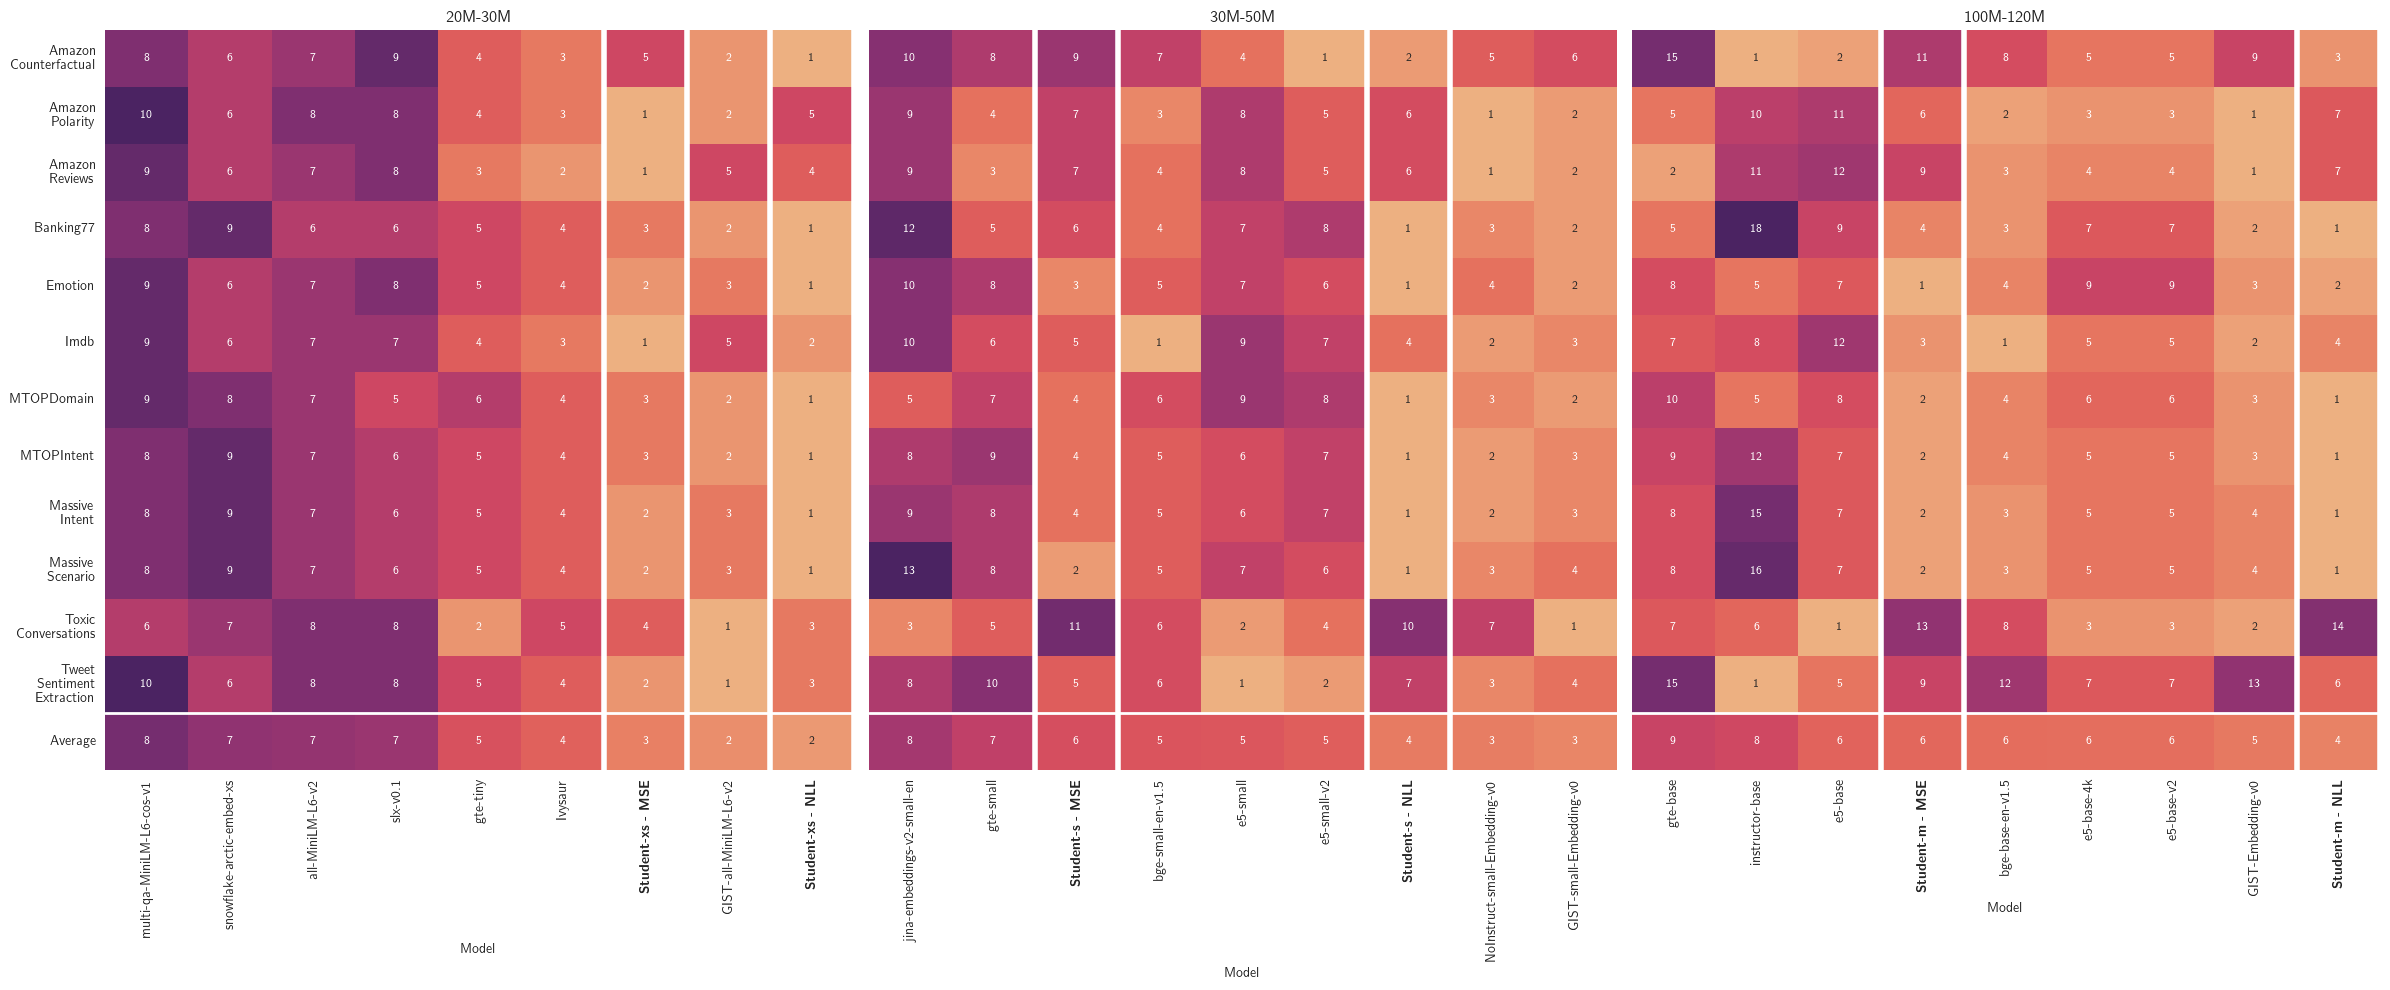

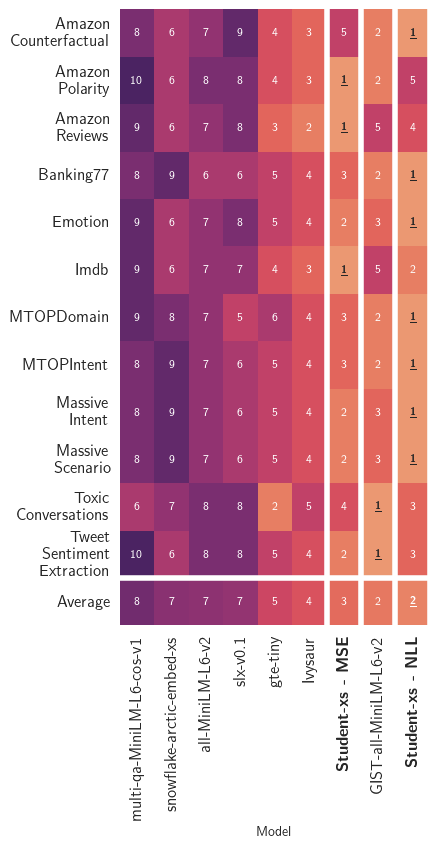

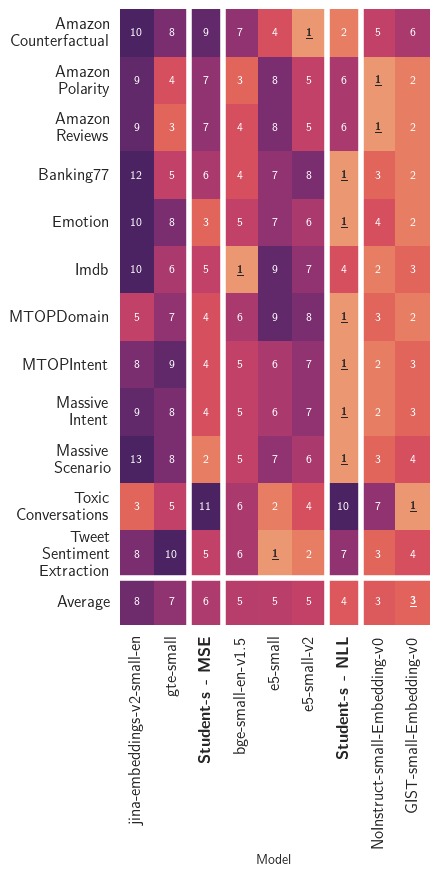

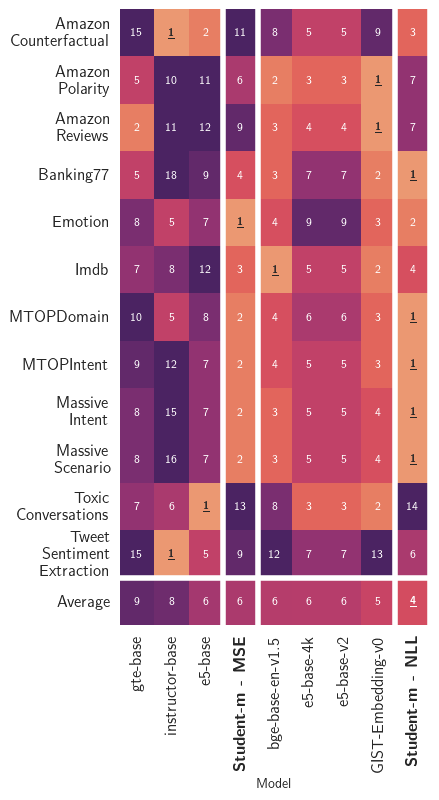

In [20]:

# to downsample

models = ['paraphrase-multilingual', 'msmarco', 'ALL', "m-v1.5", "unsup-sim"]
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{lmodern}')

size_ranges = [(20, 30), (30, 50), (100, 120)]

fig, axes = plt.subplots(1, 3, figsize=(24, 10), sharey=True)
for k, (low, high) in enumerate(size_ranges):
    figloc, axloc = plt.subplots(1, 1, figsize=(4, 8))
    ax = axes[k]
    df_rank = df_melted[(df_melted['Model Size (Million Parameters)'] >= low) & (
            df_melted['Model Size (Million Parameters)'] <= high)].copy()
    
    for model in models:
        df_rank = df_rank[~df_rank['Model'].str.contains(model)]

    df_rank['Rank'] = df_rank.groupby('Task')['Accuracy'].rank(ascending=False, method='min')

    std_per_task = df_rank.groupby('Task')['Accuracy'].std()
    # normalize in [0, 1]
    std_per_task = (std_per_task - std_per_task.min()) / (std_per_task.max() - std_per_task.min())


    df_rank['Task'] = df_rank['Task'].apply(lambda x: x.replace("Classification", ""))
    df_rank['Task'] = df_rank['Task'].apply(lambda x: re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', x))
    df_rank['Task'] = df_rank['Task'].apply(lambda x: x.replace(" (en)", ""))
    df_rank['Task'] = df_rank['Task'].apply(lambda x: x.replace(" ", " \n"))
    # df_rank['Task'] = df_rank['Task'].apply(lambda x: f"{{\\shortstack{{{x}}}")
    
    # make bold if model is Student
    df_rank['Model'] = df_rank['Model'].apply(lambda x: f"\\textbf{{{x.split('/')[-1]}}}" if "Student" in x else x.split('/')[-1])
    
    


    df_rank = df_rank.pivot_table(index='Model', columns='Task', values='Rank') # drop nan 
    
    df_rank = df_rank.dropna()

    # rename task columns: remove "Classification"
    df_rank.columns = [col.replace("Classification", "") for col in df_rank.columns]
    # remove " (en)"
    df_rank.columns = [col.replace(" (en)", "") for col in df_rank.columns]

    df_rank['Average'] = df_rank.apply(lambda x: np.average(x, weights=1 - std_per_task), axis=1)
    df_rank = df_rank[df_rank['Average'].notna()]
    df_rank = df_rank[df_rank['Average'] <= 10]
    df_rank = df_rank.sort_values('Average', ascending=False)
    # get Average index in the df_rank
    average_index = df_rank.T.index.get_loc('Average')

    ours = []
    for k, model in enumerate(df_rank.index):
        if "Student" in model:
            ours.append((k, k + 1))

    # df_rank.index = [line.split('/')[-1] for line in df_rank.index]
    sns.heatmap(df_rank.T, ax=ax, cmap='flare', annot_kws={"size": 8}, annot=True, fmt=".0f", cbar=False)
    # draw hline at average index
    ax.axhline(average_index, color='white', lw=2)
    ax.set_title(f"{low}M-{high}M")

    # add hline for ours
    for k, (start, end) in enumerate(ours):
        ax.axvline(start, color='white', lw=4)
        ax.axvline(end, color='white', lw=4)

    # sns.heatmap(df_rank.T, ax=axloc, cmap='flare', annot_kws={"size": 12}, annot=True, fmt=".0f", cbar=False, vmin=0, vmax=10)
    
    make_rank_heatmap_with_mask(df_rank.T, axloc, common_kwargs={"vmin": 0, "vmax": 10})


    # make labels bigger
    axloc.set_yticklabels(axloc.get_yticklabels(), fontsize=12, rotation=0)
    axloc.set_xticklabels(axloc.get_xticklabels(), fontsize=12, rotation=90)

    # axloc.set_title(f"Ranking per classification task for models with {low}M to {high}M parameters", fontdict={'fontsize': 20})
    axloc.axhline(average_index, color='white', lw=4)

    for k, (start, end) in enumerate(ours):
        axloc.axvline(start, color='white', lw=4)
        axloc.axvline(end, color='white', lw=4)
        


    figloc.savefig(EXPORT_PATH_FIG / f"ranking_classification_per_size_{low}_{high}.png", bbox_inches='tight')

    # export
    

fig.tight_layout()
fig.savefig(EXPORT_PATH_FIG / f"ranking_classification_per_size.png", bbox_inches='tight')





